In [1]:
!pip install catboost
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from base64 import b64decode
from io import BytesIO
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from catboost import CatBoostRegressor
import numpy as np
import torch
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/post2ctr_dataset.csv'

with open(file_path, 'r') as f:
    data = pd.read_csv(f)

In [6]:
# Преобразование изображений из base64
def decode_image(base64_string):
    return Image.open(BytesIO(b64decode(base64_string)))

data['decoded_images'] = data['photo'].apply(decode_image)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23527 entries, 0 to 23526
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   view              23527 non-null  int64 
 1   like              23527 non-null  int64 
 2   comment           23527 non-null  int64 
 3   hide              23527 non-null  int64 
 4   expand            23527 non-null  int64 
 5   open_photo        23527 non-null  int64 
 6   open              23527 non-null  int64 
 7   share_to_message  23527 non-null  int64 
 8   text              19322 non-null  object
 9   photo             23527 non-null  object
 10  decoded_images    23527 non-null  object
dtypes: int64(8), object(3)
memory usage: 2.0+ MB
None
               view          like       comment          hide         expand  \
count  2.352700e+04  23527.000000  23527.000000  23527.000000   23527.000000   
mean   2.017510e+04    382.532580     10.259064     10.739576     780.819697  

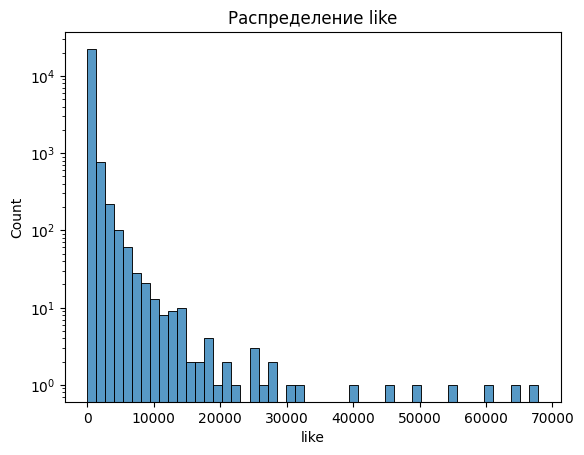

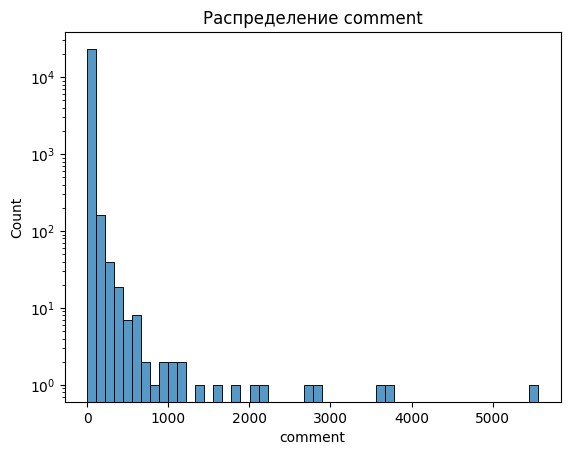

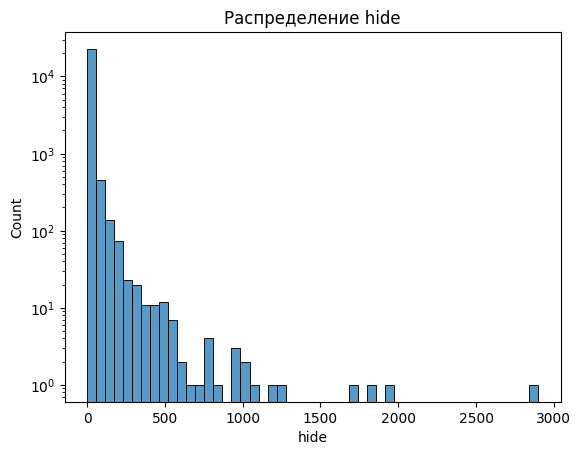

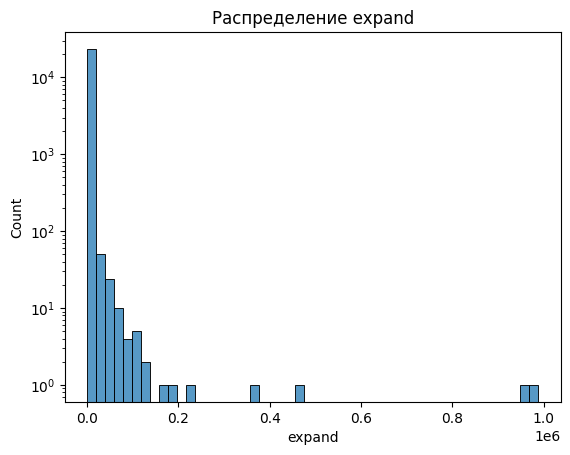

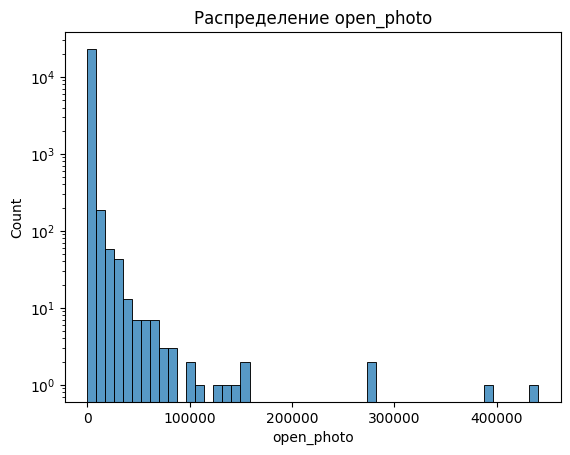

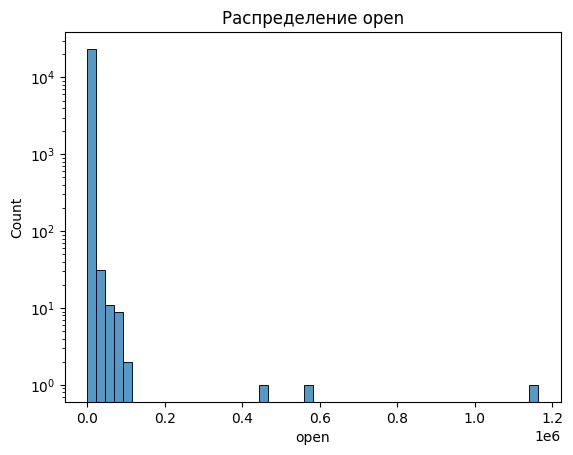

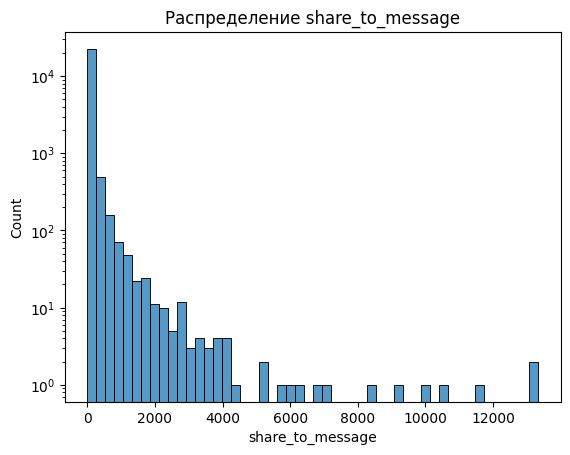

In [7]:
# Первичный анализ данных
print(data.info())
print(data.describe())

# Проверка на пропуски
print(data.isnull().sum())

# Распределение просмотров и активностей
activities = ['like', 'comment', 'hide', 'expand', 'open_photo', 'open', 'share_to_message']
for activity in activities:
    sns.histplot(data[activity], kde=False, bins=50)
    plt.yscale('log')
    plt.title(f'Распределение {activity}')
    plt.show()

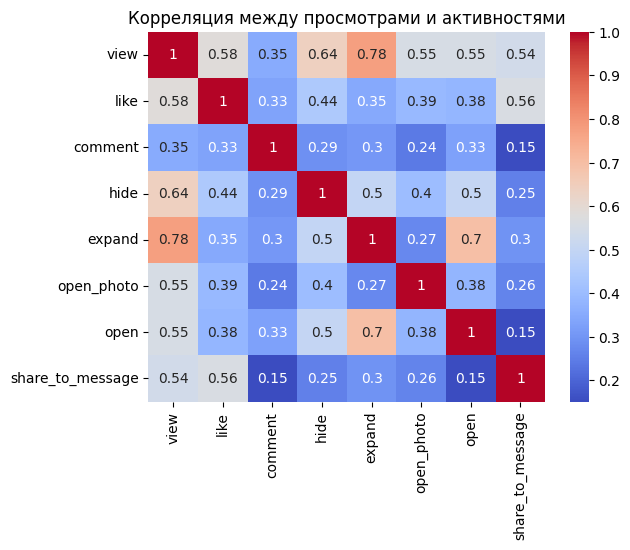

In [8]:
# Оценка корреляции между просмотрами и активностями
correlation_matrix = data[['view'] + activities].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция между просмотрами и активностями')
plt.show()

# Выбор активностей для предсказания (например, лайки и комментарии)
target_activities = ['like', 'comment']


In [9]:
nltk.download('stopwords')
nltk.download('punkt')  # Загрузка пакета для токенизации

# Очистка текста
stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    if isinstance(text, str):  # Проверка, что значение является строкой
        # Токенизация, удаление стоп-слов
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
        return ' '.join(tokens)
    return ''  # Возврат пустой строки для NaN или других типов данных

# Применение очистки текста к каждому посту
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Применение TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(data['cleaned_text']).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()  # uncomment it if you have a GPU

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [12]:
#Был выбран rubert по причине быстрой векторизации и дообучения на русских текстах

import time

# Начало времени
start_time = time.time()

# Векторизация текста
text1 = data['text'][2]
inputs = tokenizer(text1, return_tensors="pt", padding=True, truncation=True).to(device)
with torch.no_grad():
    outputs = model(**inputs)

# Конец времени
end_time = time.time()

# Расчет времени выполнения
execution_time = end_time - start_time
print(f"Время векторизации: {execution_time} секунд")


Время векторизации: 3.1547515392303467 секунд


In [13]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

data['cleaned_text'] = data['text'].apply(preprocess_text)
data['bert_embedding'] = data['cleaned_text'].apply(get_bert_embedding)
X_text_bert = np.vstack(data['bert_embedding'].values)

In [14]:
# Использование ResNet50 для извлечения признаков из изображений
model_resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def preprocess_image(img):
    if img.mode != 'RGB':  # Преобразование в RGB, если изображение не трехканальное
        img = img.convert('RGB')
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

def image_generator(data, model_resnet, batch_size):
    total_size = len(data)
    for i in range(0, total_size, batch_size):
        batch = data[i:i + batch_size]
        batch_images = np.array([preprocess_image(img) for img in batch])

        # Получение признаков из ResNet
        batch_features = model_resnet.predict(batch_images)
        yield batch_features

batch_size = 32
gen = image_generator(data['decoded_images'], model_resnet, batch_size)

X_images = []

for batch_features in gen:
    X_images.append(batch_features)

X_images = np.vstack(X_images)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

In [15]:
X_images.shape

(23527, 2048)

In [16]:
X_text_bert.shape

(23527, 312)

In [19]:
# Использую encoder-decoder  архитектуру для понижения размерности эмбедингов изображений
input_dim = X_images.shape[1]
encoding_dim = 64

input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_images, X_images, epochs=20, batch_size=32, shuffle=True)

encoder = Model(input_img, encoded)
X_images_reduced = encoder.predict(X_images)

print(f"Размерность после автокодировщика: {X_images_reduced.shape}")


Epoch 1/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4751
Epoch 2/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4064
Epoch 3/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4016
Epoch 4/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4009
Epoch 5/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4007
Epoch 6/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3980
Epoch 7/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3983
Epoch 8/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3995
Epoch 9/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3979
Epoch 10/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3983
Epoch 11/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3983
Epoch 12/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3985
Epoch 13/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3971
Epoch 14/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3964
Epoch 15/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lo

In [20]:
# Использую encoder-decoder  архитектуру для понижения размерности эмбедингов изображений
input_dim = X_text_bert.shape[1]
encoding_dim = 64  # Желаемая размерность

input_emb = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_emb)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Модель автокодировщика
autoencoder = Model(input_emb, decoded)

# Компиляция и обучение
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_text_bert, X_text_bert, epochs=20, batch_size=32, shuffle=True)

# Получение сжатого представления
encoder = Model(input_emb, encoded)
X_text_reduced = encoder.predict(X_text_bert)

print(f"Размерность после автокодировщика: {X_text_reduced.shape}")


Epoch 1/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2701
Epoch 2/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2068
Epoch 3/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2019
Epoch 4/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1991
Epoch 5/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1974
Epoch 6/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1964
Epoch 7/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1960
Epoch 8/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1959
Epoch 9/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1956
Epoch 10/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1954
Epoch 11/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1958
Epoch 12/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1946
Epoch 13/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1946
Epoch 14/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1969
Epoch 15/20
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [21]:
#При использовании SVD разложения получалось худшее качество предсказания

In [22]:
X_images_reduced.shape

(23527, 64)

In [23]:
from sklearn.model_selection import train_test_split

X = np.hstack([X_text_reduced, X_images_reduced])  # Комбинация текстовых и визуальных признаков

y = data['like'] / data['view']  # Предсказываю конверсию в лайк
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train.shape

(18821, 128)

In [25]:
# Градиентный бустинг для регрессии
gb_reg = CatBoostRegressor(
    task_type='GPU',
    verbose=0)
gb_reg.fit(X_train, y_train)

In [26]:
# Предсказание
y_pred_gb = gb_reg.predict(X_test)

# Оценка модели
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r_squared = r2_score(y_test, y_pred_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_pred_gb)


print(f'Gradient Boosting MAE: {mae_gb}')
print(f'Gradient Boosting R^2: {r_squared}')
print(f'Gradient Boosting MAPE: {mape_gb}')

Gradient Boosting MAE: 0.018392081591677312
Gradient Boosting R^2: 0.22104621019353388
Gradient Boosting MAPE: 505427062943.6417


In [27]:
#В качестве финальной модели лучше всего себя показал градиентый бустинг, среди реализаций был выбран catboost т.к. наименее требователен к настройке параметров